In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def waterbalance(
    filepath: str, 
    precipitation_col: str, 
    evapotranspiration_col: str, 
    runoff_col: str, 
    subbasin_area: float
) -> pd.DataFrame:
    """
    Computes the water balance with P-E-Q given a filepath to a .txt file, three column names, and the 
    subbasin area. The area is used to convert units. Column selections can be changed. REMEMBER TO CHANGE 
    AREA IF USING DIFFERENT SUBBASIN.

    Args:
        filepath (str): The path to the HYPE subbasin .txt file.
        precipitation_col (str): The column name for precipitation data.
        evapotranspiration_col (str): The column name for evapotranspiration data.
        runoff_col (str): The column name for runoff data.
        subbasin_area (float): The area of the subbasin in square meters (from GeoData or shapefile).

    Returns:
        pd.DataFrame: A DataFrame containing a single column representing the water balance.
    """
    # Read the file into a DataFrame
    df = pd.read_csv(filepath, sep='\t', index_col=0)
    
    # Delete the first row from the DataFrame
    df = df.iloc[1:]
    
    # Create the waterbalance DataFrame with one column
    waterbalance = pd.DataFrame(index=df.index, columns=['Water Balance (mm)'])
    
    # Convert all the data to float, replacing non-numeric values with NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Convert runoff units from m^3/s to mm/day
    df[runoff_col] = df[runoff_col] * 1000 * 86400 / subbasin_area
    
    # Calculate the water balance values and populate the column
    waterbalance['Water Balance (mm)'] = df[precipitation_col] - df[evapotranspiration_col] - df[runoff_col]
    
    # Return the waterbalance DataFrame
    return waterbalance


In [3]:
def wb_storage(
    filepath: str, 
    subbasin_area: float
) -> pd.DataFrame:
    """
    Computes the change in storage for each timestep given a filepath to the HYPE output basin.txt file, 
    The columns must be changed manually within this function if required. The subbasin area is given in case 
    of unit conversions.

    Args:
        filepath (str): The path to the HYPE subbasin .txt file

    Returns:
        pd.DataFrame: A DataFrame containing a single column representing the change in storage (mm/day).
    """
    # Read the file into a DataFrame
    df = pd.read_csv(filepath, sep='\t', index_col=0)
    
    # Delete the first row from the DataFrame
    df = df.iloc[1:]
    
    # Create the waterbalance DataFrame with one column
    storage_change = pd.DataFrame(index=df.index[1:], columns=['Storage Change (mm)'])
    
    # Convert all the data to float, replacing non-numeric values with NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Calculate the change in storage values and populate the column
    storage_change['Storage Change (mm)'] = df['soim'].diff() + df['snow'].diff()
    
    # Return the storage_change DataFrame
    return storage_change


In [4]:
def waterbalance_plot(
    df1: pd.DataFrame, 
    df2: pd.DataFrame, 
    subbasin_id: str, 
    start_date=None, 
    end_date=None
):
    """
    Plots two DataFrames containing the sides of the water balance equation as a line plot.

    Args:
        df1 (pd.DataFrame): the dataframe containing P-E-Q.
        df2 (pd.DataFrame): The dataframe containing the change in storage.
        subbasin_id (str): The subbasin ID for the plot title.
        start_date (str, optional): The start date for plotting (format: 'YYYY-MM-DD').
        end_date (str, optional): The end date for plotting (format: 'YYYY-MM-DD').

    Returns:
        None (Displays the plot).
    """
    # Use the first column of each DataFrame for plotting
    column_name_1 = df1.columns[0]
    column_name_2 = df2.columns[0]

    # Convert index to datetime if not already in that format
    if not isinstance(df1.index, pd.DatetimeIndex):
        df1.index = pd.to_datetime(df1.index)
    if not isinstance(df2.index, pd.DatetimeIndex):
        df2.index = pd.to_datetime(df2.index)

    # Filter data within the specified date range if start_date and end_date are provided
    if start_date is not None and end_date is not None:
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        df1 = df1.loc[start_date:end_date]
        df2 = df2.loc[start_date:end_date]

    # Create a larger plot
    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figsize as needed

    # Plot the first DataFrame
    ax.plot(df1.index, df1[column_name_1], label='P-E-Q')

    # Reindex the second DataFrame to align with the index of the first DataFrame
    df2_aligned = df2.reindex(df1.index)

    # Plot the second DataFrame against the index of the first DataFrame
    ax.plot(df1.index, df2_aligned[column_name_2], label='Change in Storage')

    # Set labels and title with subbasin ID
    ax.set_xlabel('Date')
    ax.set_ylabel('Depth (mm)')  # Using the column name of the first DataFrame
    ax.set_title(f'P-E-Q vs Change in Storage for Subbasin ID: {subbasin_id}')
    
     # Add labels on the x-axis
    if start_date is None and end_date is None:
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))

    if start_date is not None and end_date is not None:
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date)
        delta_years = (end - start).days / 365.25  # Account for leap years
        if delta_years <= 2:
            plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
        elif 2 < delta_years <= 6:
            plt.gca().xaxis.set_major_locator(mdates.YearLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=3))
        elif delta_years > 6:
            plt.gca().xaxis.set_major_locator(mdates.YearLocator())
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

    # Add a legend
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


In [5]:
def wb_error(
    df1: pd.DataFrame, 
    df2: pd.DataFrame
) -> None:
    """
    Performs a subtraction between the RHS and LHS side of water balance equation and analyzes the distance from 0.
    Prints the results.

    Parameters:
        df1 (pd.DataFrame): P-E-Q of waterbalance equation
        df2 (pd.DataFrame): Change in storage of waterbalance equation

    Returns:
        None: It prints the error analysis.
    """

    # Drop the first row from df1
    df1 = df1.iloc[1:]

    # Drop any rows in df2 that are not present in df1
    df2 = df2.loc[df2.index.isin(df1.index)]

    # Check if there are any NaN values in df2 after dropping the rows
    if df2.isnull().any().any():
        print("Error: Dataframes have different index values and cannot be aligned.")
        return

    # Subtract depths from the first dataframe and create the third dataframe
    df3 = pd.DataFrame(df1['Water Balance (mm)'] - df2['Storage Change (mm)'], columns=['result'])

    # Calculate the distance from 0 for each value in df3
    df3['distance_from_zero'] = df3['result'].abs()

    # Analyze the distance from 0 in df3
    mean_distance = df3['distance_from_zero'].mean()
    median_distance = df3['distance_from_zero'].median()
    min_distance = df3['distance_from_zero'].min()
    max_distance = df3['distance_from_zero'].max()

    # Print the error analysis
    print("Error Analysis:")
    print("Mean Distance from 0 (mm):", mean_distance)
    print("Median Distance from 0 (mm):", median_distance)
    print("Minimum Distance from 0 (mm):", min_distance)
    print("Maximum Distance from 0 (mm):", max_distance)


Areas for subbasins of note:
58308= 56020600 m^2
58354= 241713000 m^2
58408= 175734099 m^2
58567= 92141000 m^2

In [6]:
waterbalance_LHS=waterbalance('/home/paulc600/local/HYPE/08_outputs/0058567.txt', 'cprc', 'evap', 'clof', 92141000)

/tmp/ipykernel_20641/10834940.py:24: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t', index_col=0)


In [7]:
waterbalance_LHS

,Water Balance (mm)
DATE,
1980-01-01,0.000000
1980-01-02,0.000000
1980-01-03,0.118308
1980-01-04,-0.005626
1980-01-05,8.195312
...,...
2018-12-27,0.449000
2018-12-28,0.003000
2018-12-29,0.255368


In [8]:
waterbalance_RHS=wb_storage('/home/paulc600/local/HYPE/08_outputs/0058567.txt',175734099)

/tmp/ipykernel_20641/4219278060.py:17: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t', index_col=0)


In [9]:
waterbalance_RHS

,Storage Change (mm)
DATE,
1980-01-02,0.000
1980-01-03,0.118
1980-01-04,-0.005
1980-01-05,8.195
1980-01-06,1.506
...,...
2018-12-27,0.448
2018-12-28,0.003
2018-12-29,0.256


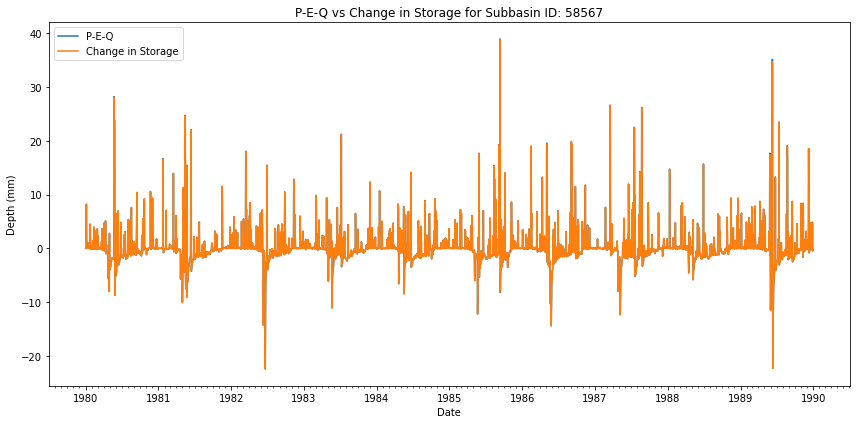

In [10]:
waterbalance_plot(waterbalance_LHS, waterbalance_RHS, '58567','1980-01-01', '1990-01-01')

In [11]:
wb_error(waterbalance_LHS, waterbalance_RHS)

Error Analysis:
Mean Distance from 0 (mm): 0.005063916965736181
Median Distance from 0 (mm): 0.0009376933177297486
Minimum Distance from 0 (mm): 0.0
Maximum Distance from 0 (mm): 0.43051962752731043
